In [1]:
cd ../TileEM/

/srv/data/home/jlee782/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from paper_visualizations import * 
from PixelEM import * 
from test_sample import test_sample_obj
import json
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [5]:
df = pd.read_csv("all_info.csv",index_col=0)
df_object_batch = pd.read_csv("all_object_batch_info.csv",index_col=0)
df_worker = pd.read_csv("all_worker_response_info.csv",index_col=0)
df_object = pd.read_csv("all_object_info.csv",index_col=0)
df_tile = pd.read_csv("all_tile_info.csv",index_col=0)

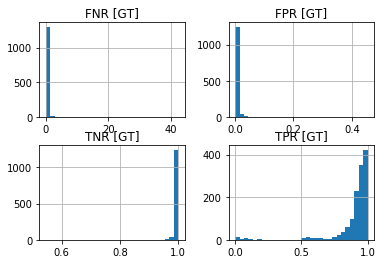

In [4]:
fig = df_worker[['TPR [GT]', u'FNR [GT]', u'TNR [GT]','FPR [GT]']].hist(bins=30)

In [34]:
print "Mean:\n",df_worker[['TPR [GT]', u'FNR [GT]', u'TNR [GT]','FPR [GT]']].mean()
print "Stdev:\n",df_worker[['TPR [GT]', u'FNR [GT]', u'TNR [GT]','FPR [GT]']].std()

Mean:
TPR [GT]    0.899327
FNR [GT]    0.206009
TNR [GT]    0.994096
FPR [GT]    0.005904
dtype: float64
Stdev:
TPR [GT]    0.161137
FNR [GT]    1.709599
TNR [GT]    0.023444
FPR [GT]    0.023444
dtype: float64


Among the worker responses, workers do more badly in TPR and FNR. This indicates that workers tend to underbound by more than they overbound. We characterize a worker as "overbounding" if his FPR is higher than the average, ditto for "underbounding". 

In [110]:
df["is_overbounding"]=df_worker["FPR [GT]"]>df_worker["FPR [GT]"].mean()
df["is_underbounding"]=df_worker["FNR [GT]"]>df_worker["FNR [GT]"].mean()

df["gt overlap norm GT area"]=df["gt overlap area"]/df["GT area"]

df["gt overlap norm tarea"]=df["gt overlap area"]/df["tile area"]

most tiles are small tiles 

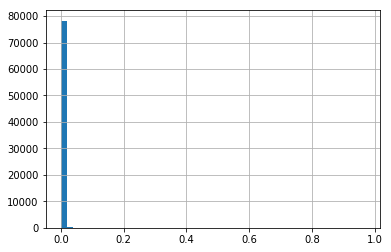

In [50]:
df["gt overlap fraction"].hist(bins=50)

- data--> model
- features: 
- how many tiles there are that overlap with ground t11ruth? Look at their distribution
- for each tile, how much is inside and outside the grround truth. (justification of maximum tile performance) 
- For tiles that are partially overlapping, what fraction of it is inside and what fraction of it is outside. 

# Tile overlap distribution analysis

In [182]:
def plot_tile_overlap_distribution(batch,objid,small_tiles=True):
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    avrg_tarea = df_tile_subset["tile area"].mean()
    if small_tiles: df_tile_subset = df_tile_subset[df_tile_subset["tile area"]<avrg_tarea]
    ydata  = df_tile_subset["tile area"]-df_tile_subset["gt overlap area"]
    xdata  = df_tile_subset["gt overlap area"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title("{}; obj{}".format(batch,objid))
    if small_tiles: plt.title("{}; obj{} [small tiles only]".format(batch,objid))
    plt.scatter(xdata,ydata,marker='.',label="Tile")
    partial_frac = len(np.where((xdata!=0)&(ydata!=0))[0])/float(len(ydata))*100
    plt.text(0.87, 0.75,"Partial:{:.2f}%".format(partial_frac),horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    plt.text(0.85, 0.70,"Area Cutoff:{:.2f}".format(avrg_tarea),horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    plt.text(0.87, 0.65,"Total Tiles:{}".format(len(ydata)),horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    x = np.linspace(0,xdata.max())
    def f(x,alpha=1.):
        return alpha*x
    plt.plot(x,f(x),'--',color='red',label="y=x")
    #plt.plot(x,f(x,0.2),'--',color='green',label="y=0.2x")
    # plt.plot(x,f(x,1.2),'--',color='green',label="y=1.2x")
    plt.legend(loc='upper right')
    plt.xlabel("Intersection area",fontsize=13)
    plt.ylabel("Outside area",fontsize=13)

# CHECK: discard zero area tiles 

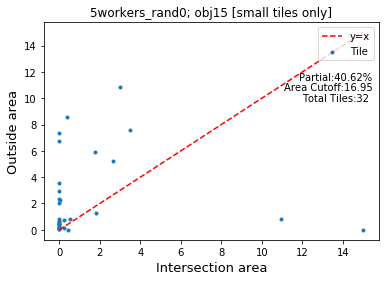

In [183]:
plot_tile_overlap_distribution( '5workers_rand0',15)

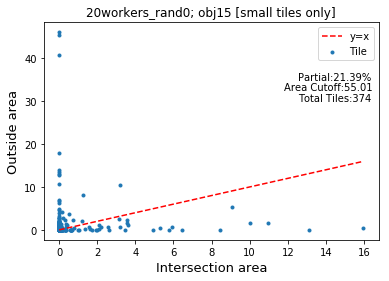

In [184]:
plot_tile_overlap_distribution('20workers_rand0',15)

The percentage of partials is fairly large but the points still lie close to y=0 and x=0 

For this object there was a large object (dog) that some worker circled which was non-overlapping with GT, this is why the outside area is so large compared to the actual GT (car in background)

- number of partial tiles = total tiles - completely outside tiles - completely inside tiles 

- percentage of partial tiles = number of partial tiles / total tiles 


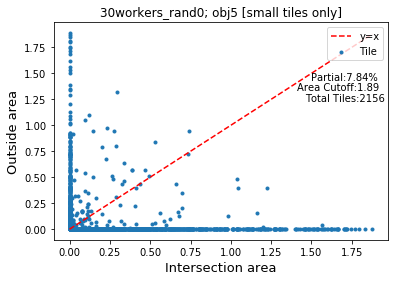

In [185]:
plot_tile_overlap_distribution('30workers_rand0',5)

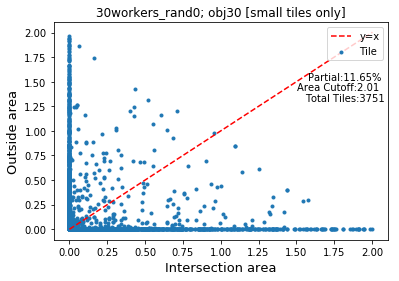

In [186]:
plot_tile_overlap_distribution('30workers_rand0',30)

### [*]compare with where MV does wrong 

# Worker Quality 

In [6]:
df_worker_tile = pd.read_csv("all_worker_tile_info.csv",index_col=0)

we only show this for tiles that are highly voted by many workers 

In [23]:
df = df_worker.merge(df_tile)
def plot_overlap_vs_worker_quality(batch,objid,y_attr):
    df_tile_subset = df[(df["batch"]==batch)&(df["objid"]==objid)]
    df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
    tile_lst = list(set(df_tile_subset["tile id"]))
    for tidx in tile_lst:
        yes_workers= df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values
        selected = df_tile_subset[(df_tile_subset["tile id"]==tidx)&(df_tile_subset["worker id"].isin(yes_workers))]
        no_selected = df_tile_subset[(df_tile_subset["tile id"]==tidx)&(~df_tile_subset["worker id"].isin(yes_workers))]
        if len(no_selected)>0:
            xdata = no_selected['gt overlap area']/no_selected['tile area']
            ydata = no_selected[y_attr]
            plt.plot(xdata,ydata,'.',color='red')
        if len(selected)>0:
            xdata = selected['gt overlap area']/selected['tile area']
            ydata = selected[y_attr]
            plt.plot(xdata,ydata,'x',color='green')

    plt.title("{}; obj{}".format(batch,objid))
    plt.xlabel("overlap fraction",fontsize=13)
    plt.ylabel(y_attr,fontsize=13)
    plt.xlim(0,1.1)
    plt.legend(['unvoted','voted'],loc="lower right",fontsize=12)

In [54]:
# hist,bin_edges = np.histogram(tile_area,100)
# bin_idx = np.digitize(tile_area,bin_edges)
# bin_idx

In [53]:
bin_edges = [np.percentile(tile_area,75),np.percentile(tile_area,90)]
bin_idx = np.digitize(tile_area,bin_edges)
bin_idx

array([0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0,
       0, 2, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1])

In [97]:
tile_area.remove(max(tile_area))
tile_area.remove(max(tile_area))

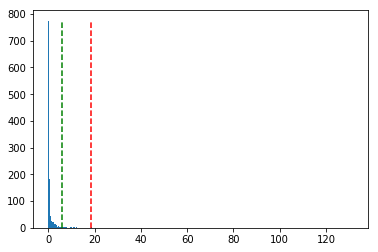

In [99]:
a = plt.hist(tile_area,bins=500)
plt.vlines(np.percentile(tile_area,95),0,a[0].max(),linestyles='--',colors='green')
plt.vlines(np.percentile(tile_area,99),0,a[0].max(),linestyles='--',colors='red')

In [109]:
ymin,ymax= ax.get_ylim()

(0.8358809171878, 0.97851267645149986)

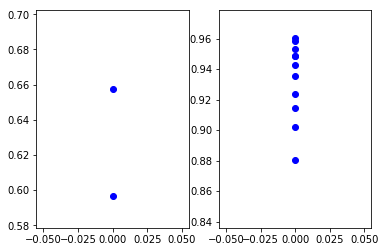

In [126]:
fig,(ax,ax2) = plt.subplots(1, 2, sharex=True)

# plot the same data on both axes
ax.plot(xdata, ydata, 'bo')
ax2.plot(xdata, ydata, 'bo')

ax.set_ylim(ymin,np.percentile(ydata,10)) 
ax2.set_ylim(np.percentile(ydata,15),ymax)


In [102]:
ydata.mean()

0.88628911081346162

In [171]:
def plot_overlap_vs_worker_quality(batch,objid,y_attr):
    bin2size={0:'small',1:'medium',2:'large'}
    df_tile_subset = df[(df["batch"]==batch)&(df["objid"]==objid)]
    df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
    tile_lst = np.array(list(set(df_tile_subset["tile id"])))
    tile_area = list(set(df_tile_subset["tile area"]))
    bin_edges = [np.percentile(tile_area,95),np.percentile(tile_area,99)]
    bin_idx = np.digitize(tile_area,bin_edges)
    for size in list(set(bin_idx)):
        fig,(ax,ax2) = plt.subplots(1, 2, sharex=True)
        idx = np.where(bin_idx==size)[0]
        for tidx in tile_lst[idx]:
            yes_workers= df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values
            selected = df_tile_subset[(df_tile_subset["tile id"]==tidx)&(df_tile_subset["worker id"].isin(yes_workers))]
            no_selected = df_tile_subset[(df_tile_subset["tile id"]==tidx)&(~df_tile_subset["worker id"].isin(yes_workers))]

            xdata1 = no_selected['gt overlap area']/no_selected['tile area']
            ydata1 = no_selected[y_attr]
            #plt.plot(xdata,ydata,'.',color='red')

            ax.plot(xdata1, ydata1,'.',color='red')
            ax2.plot(xdata1, ydata1,'.',color='red')

            xdata = selected['gt overlap area']/selected['tile area']
            ydata = selected[y_attr]
            #plt.plot(xdata,ydata,'x',color='green')
            ax.plot(xdata, ydata,'x',color='green')
            ax2.plot(xdata, ydata,'x',color='green')

            ymin,ymax= ax.get_ylim()
    #         ax.set_ylim(ymin,np.percentile(ydata,10)) 
    #         ax2.set_ylim(np.percentile(ydata,15),ymax)
            ax.set_ylim(min(ydata1)-0.03,0.7) # Definition of bad workers
            ax2.set_ylim(0.85,max(ydata1)+0.03)# Definition of good workers
    #         print len(selected),len(no_selected)
    #     plt.legend(['unvoted','voted'],loc="lower right",fontsize=12)
        plt.legend(['unvoted','voted'],bbox_to_anchor=(1.7,1), loc="upper right",fontsize=12)
        fig.text(0.5, 1,"{}; obj{} [{}]".format(batch,objid,bin2size[size]), ha='center',fontsize=14)
        fig.text(0.5, 0, 'overlap fraction', ha='center',fontsize=13)
        fig.text(0.0, 0.5,y_attr, va='center', rotation='vertical',fontsize=13)

        plt.xlim(-0.1,1.1)

        plt.tight_layout()

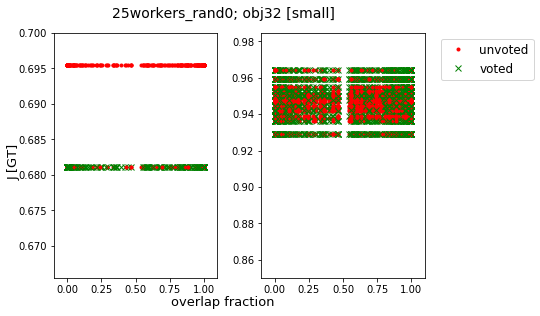

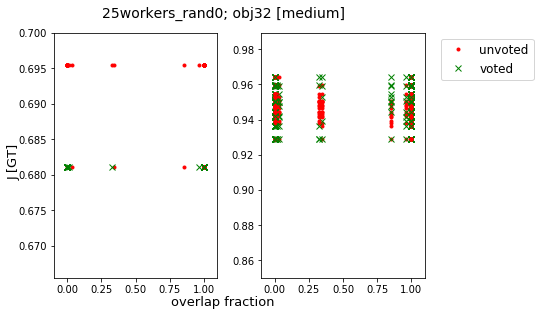

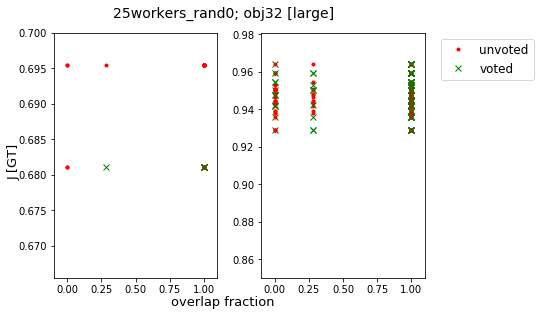

In [174]:
plot_overlap_vs_worker_quality('25workers_rand0',32,'J [GT]')

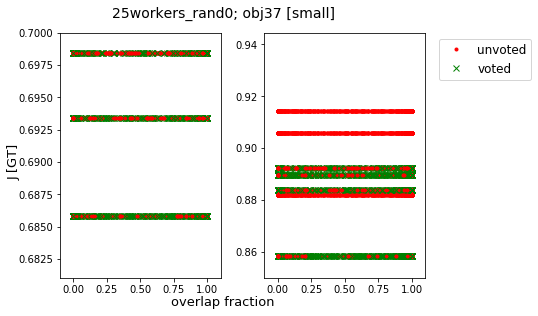

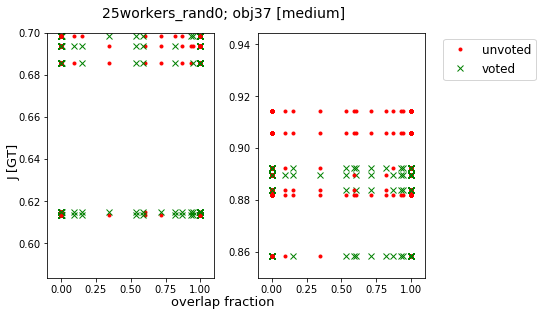

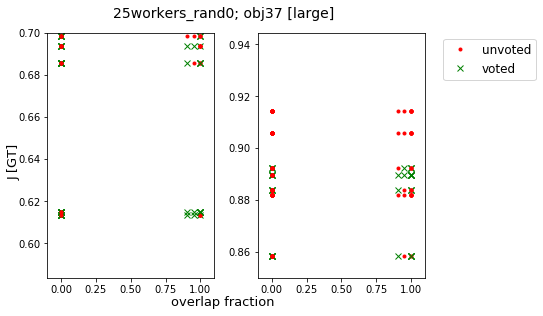

In [173]:
plot_overlap_vs_worker_quality('25workers_rand0',37,'J [GT]')

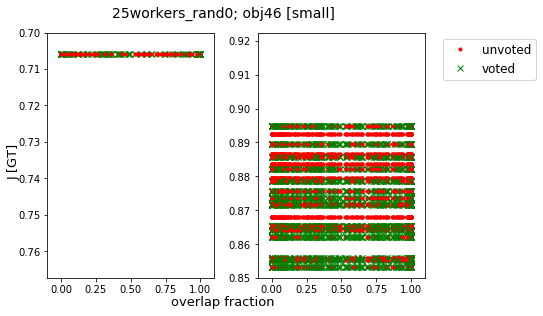

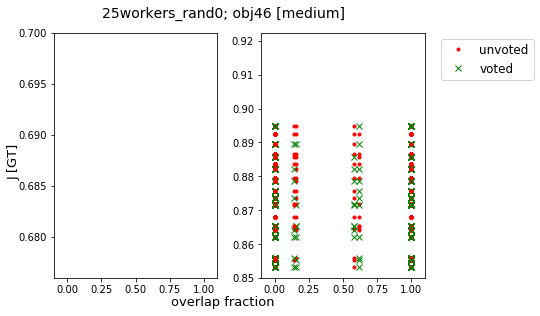

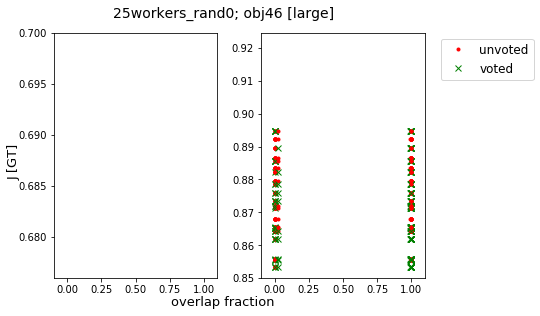

In [172]:
plot_overlap_vs_worker_quality('25workers_rand0',46,'J [GT]')

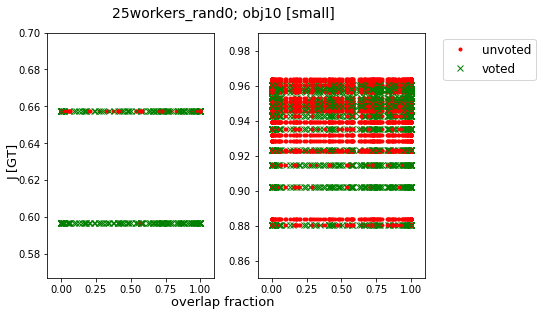

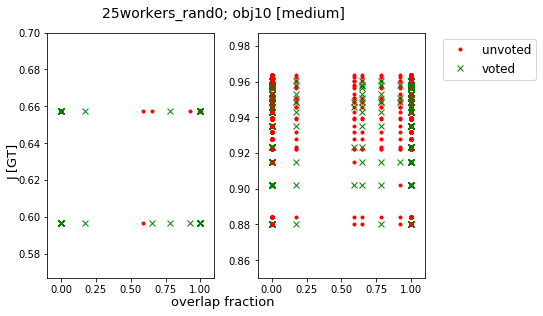

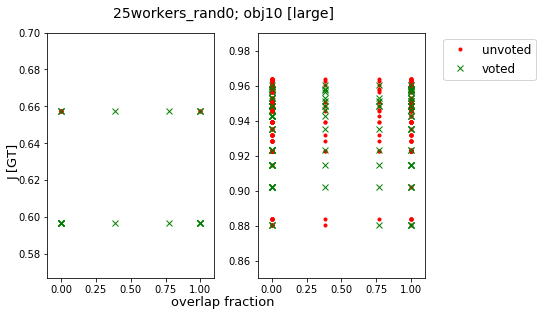

In [166]:
plot_overlap_vs_worker_quality('25workers_rand0',10,'J [GT]')

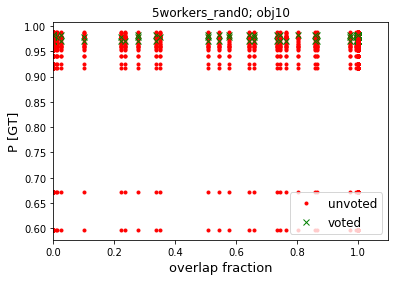

In [66]:
plot_overlap_vs_worker_quality('5workers_rand0',10,'P [GT]')

##### convergence of worker qualities (i.e. picked the same tiles combination) is higher for tiles which are completely inside or outside (i.e. overlap fractions of 0 or 1)

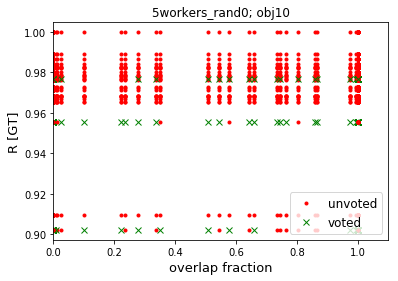

In [25]:
plot_overlap_vs_worker_quality('5workers_rand0',10,'R [GT]')

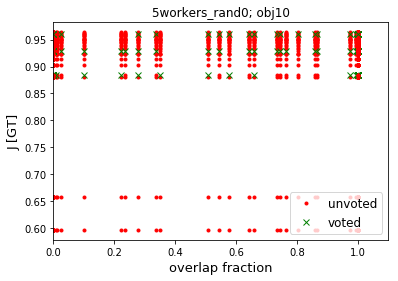

In [26]:
plot_overlap_vs_worker_quality('5workers_rand0',10,'J [GT]')

- ~~separate by small tile, medium tile and large tiles ~~
- [*] what is the turnover where worker switch from red to green? 

Each vertical line represents a tile. Every horizontal line represents a worker. 

In [11]:
df = df_worker.merge(df_tile)
def plot_overlap_vs_area_weighted_prob(batch,objid):
    df_tile_subset = df[(df["batch"]==batch)&(df["objid"]==objid)]
    df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
    tile_lst = list(set(df_tile_subset["tile id"]))
    image_area = float(df_object[df_object["objid"]==objid]["Image area"])
    for tidx in tile_lst:
        yes_workers= list(set(df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values))
        no_workers= list(set(df_worker_tile_subset[(df_worker_tile["tile id"]!=tidx)]["worker id"].values))
        weighted_area = 0
        for wid in list(set(df_tile_subset["worker id"])):
            df_this = df_tile_subset[(df_tile_subset["worker id"]==wid)&(df_tile_subset["tile id"]==tidx)]
            if wid in no_workers:
                weighted_area+= (float(df_this["tile area"].values) - float(df_this["gt overlap area"].values))
            elif wid in yes_workers:
                weighted_area+=float(df_this["gt overlap area"].values)
        weighted_qj = weighted_area/image_area
        xdata = float(df_this['gt overlap area'])/float(df_this['tile area'])
        plt.plot(xdata,weighted_qj,'o',color="blue")
    plt.title("{}; obj{}".format(batch,objid))
    plt.xlabel("overlap fraction",fontsize=13)
    plt.ylabel("area-weighted prob of tile correct",fontsize=13)
    plt.xlim(0,1.1)
    plt.legend(['worker vote on tile'],loc="upper left",fontsize=12)

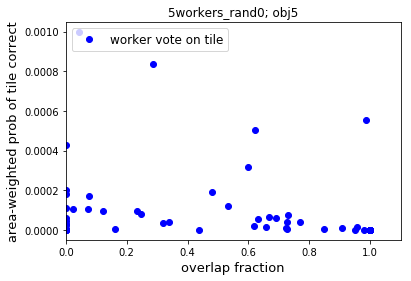

In [12]:
plot_overlap_vs_area_weighted_prob('5workers_rand0',5)

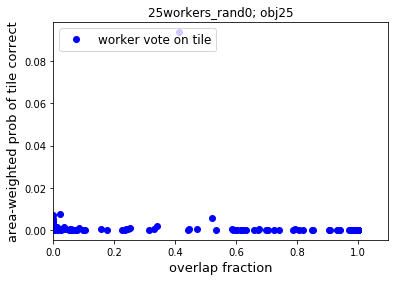

In [13]:
plot_overlap_vs_area_weighted_prob('25workers_rand0',25)

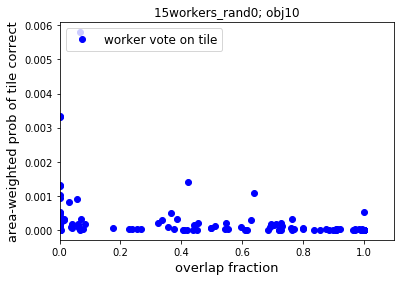

In [14]:
plot_overlap_vs_area_weighted_prob('15workers_rand0',10)

# Histogram of mistakes: 
- treat if overlap fraction >0.5 then we pick it, what is the accumlated area of mistake (of the external area) that we would make 